In [1]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")

('./fr.openfoodfacts.org.products.csv.zip',
 <http.client.HTTPMessage at 0x1c2ed67f020>)

In [2]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zipRef:
    with zipRef.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

In [3]:
varList = data.columns.tolist()
sizeData = data.shape[0]
print(varList)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

In [4]:
startNut = varList.index("energy_100g")
print(startNut)

63


In [5]:
size = data[data.duplicated()].shape[0]
if size == 0:
    print("No exact duplicated")
else:
    print(f"exact duplicated :{size}")
subset = ['code']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"exact duplicated with subset {subset} :{size}")
subset = ['product_name', 'creator', 'quantity']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")
subset = ['product_name', 'brands', 'quantity', 'categories', 'countries']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")


No exact duplicated
No possible duplicated with subset : ['code']
Possible duplicated with subset ['product_name', 'creator', 'quantity'] :1939
Possible duplicated with subset ['product_name', 'brands', 'quantity', 'categories', 'countries'] :138


In [6]:
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
print(missingRate.shape[0])
print(missingRate[missingRate >= 0.5])

63
generic_name                                  0.835413
quantity                                      0.673229
packaging                                     0.753844
packaging_tags                                0.753841
categories                                    0.736854
categories_tags                               0.736919
categories_fr                                 0.736850
origins                                       0.930823
origins_tags                                  0.930938
manufacturing_places                          0.886209
manufacturing_places_tags                     0.886228
labels                                        0.854853
labels_tags                                   0.854588
labels_fr                                     0.854520
emb_codes                                     0.908639
emb_codes_tags                                0.908649
first_packaging_code_geo                      0.941382
cities                                        0.999928
cities_

In [7]:
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
print(missingRateNut.shape[0])
print(missingRateNut[missingRateNut >= 0.5])

99
energy-from-fat_100g     0.997328
butyric-acid_100g        1.000000
caproic-acid_100g        1.000000
caprylic-acid_100g       0.999997
capric-acid_100g         0.999994
                           ...   
cocoa_100g               0.997045
chlorophyl_100g          1.000000
carbon-footprint_100g    0.999165
glycemic-index_100g      1.000000
water-hardness_100g      1.000000
Length: 88, dtype: float64


In [8]:
def prepareData(data, targetColumn, subsetDup):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")

    dataCleaned = data.dropna(subset=[targetColumn])
    y = dataCleaned[targetColumn]
    X = dataCleaned.drop(columns=[targetColumn])

    columnsKeep = X.columns[X.isnull().mean() < 0.5]
    X = X[columnsKeep]
    
    subsetDup = [col for col in subsetDup if col in X.columns]
    
    if subsetDup:
        X = X.drop_duplicates(subset=subsetDup)
        y = y.loc[X.index]
    else:
        print("No target for subsetDup.")
    return X, y

on calcul consiste à faire la différence, pour 100 gr ou 100 mL de produit, entre les composantes négatives (sucres, sel, acides gras saturés) et positives (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive) d'un aliment afin de lui attribuer une note
La categorie joue aussi un role les seuil differe

In [9]:
try:
    subsetDup = ['product_name', 'brands', 'quantity', 'categories', 'countries']
    XClean, y = prepareData(data, 'nutrition-score-fr_100g', subsetDup)

    print("Nb raws after clean :", len(XClean))
    print("Nb features:", XClean.shape[1])
    columnsX = XClean.columns.tolist()
    print("\n10 first features:")
    print(columnsX[:10])
    startNut = columnsX.index("energy_100g")
    print("\nFeatures nutritional:")
    print(columnsX[startNut : ])
    print("\nDistribution of the target variable:")
    print(y.value_counts(normalize=True))
    
    print("\nDescriptive statistics for some numeric columns:")
    numericColumns = [
    'energy_100g',
    'energy-from-fat_100g', 
    'fat_100g',
    'saturated-fat_100g', 
    'sugars_100g' ,
    'salt_100g', 
    'sodium_100g',
    'fiber_100g',
    'proteins_100g',
    'fruits-vegetables-nuts_100g',
    'nutrition-score-uk_100g'
    ]
    print(f'Features needed in Nutriscoring : {numericColumns}')
    numericColumns = [col for col in numericColumns if col in XClean.columns]
    print(numericColumns)
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(XClean[numericColumns].describe())

except Exception as e:
    print(f"Error : {e}")

Nb raws after clean : 205268
Nb features: 41

10 first features:
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags']

Features nutritional:
['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-uk_100g']

Distribution of the target variable:
nutrition-score-fr_100g
 0.0     0.057257
 1.0     0.050919
 14.0    0.050807
 2.0     0.047801
 13.0    0.039919
-1.0     0.039509
 11.0    0.039193
 12.0    0.038886
 3.0     0.035495
 15.0    0.034384
 10.0    0.031578
 20.0    0.031340
 16.0    0.029863
 21.0    0.028986
 9.0     0.028665
 4.0     0.028241
-2.0     0.027905
 19.0    0.027661
 17.0    0.027252
 18.0    0.025737
 8.0     0.023306
-3.0     0.023043
-6.0     0.022858
 5.0     0.022

In [10]:
def cleanOutliers(data, columns, lowerPercentile=0.01, upperPercentile=0.9999):
    dataClean = data.copy()
    for col in columns:
        if np.issubdtype(dataClean[col].dtype, np.number):
            lower = dataClean[col].quantile(lowerPercentile)
            upper = dataClean[col].quantile(upperPercentile)
            dataClean[col] = dataClean[col].clip(lower, upper)
        else:
            print(f"Column {col} not a number.")
    return dataClean

In [11]:
XClean = cleanOutliers(XClean, numericColumns)

In [12]:
def plotBoxplots(data, columns):
    print(columns)
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=data[col])
    plt.tight_layout()
    plt.show()

In [13]:
def plotHistograms(data, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g', 'nutrition-score-uk_100g']


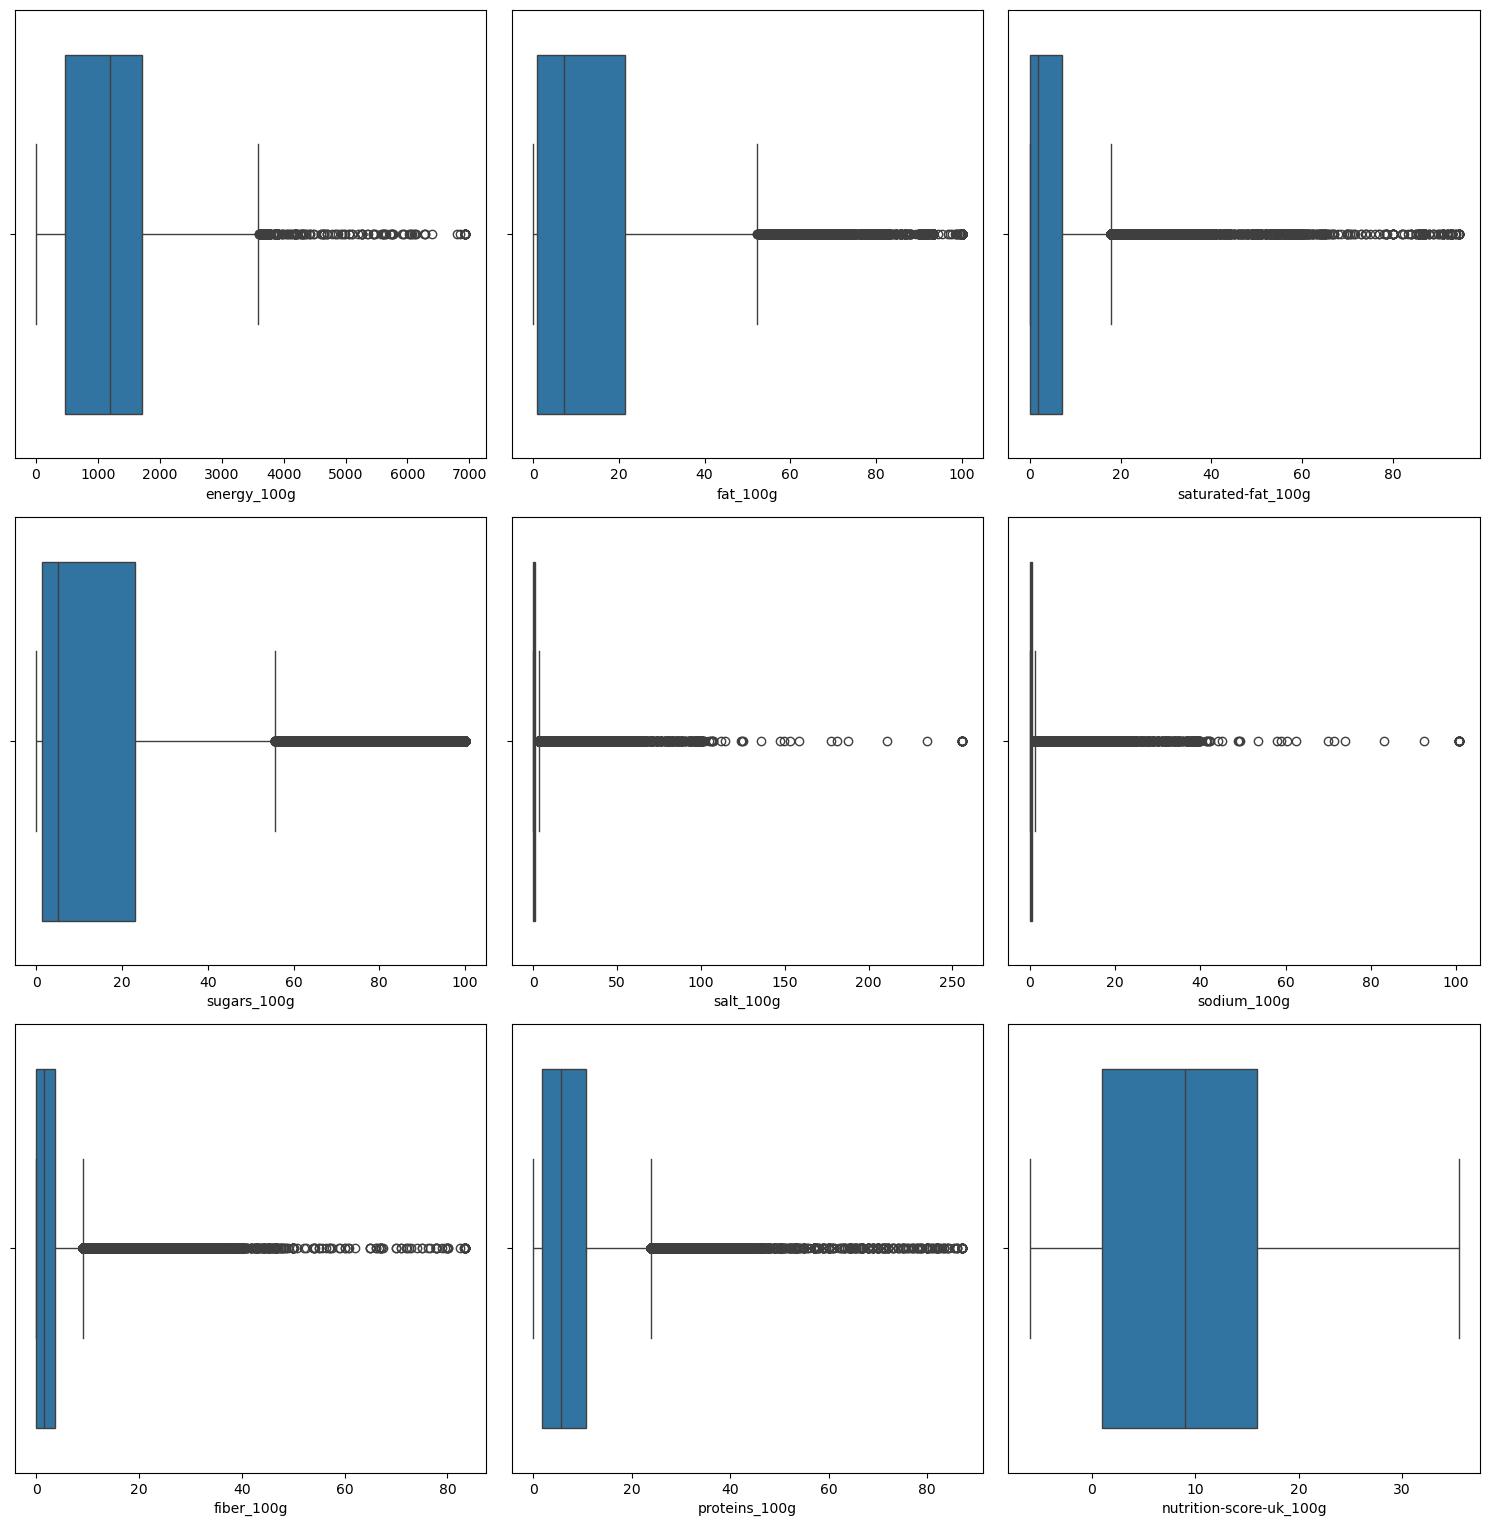

In [14]:
plotBoxplots(XClean, numericColumns)

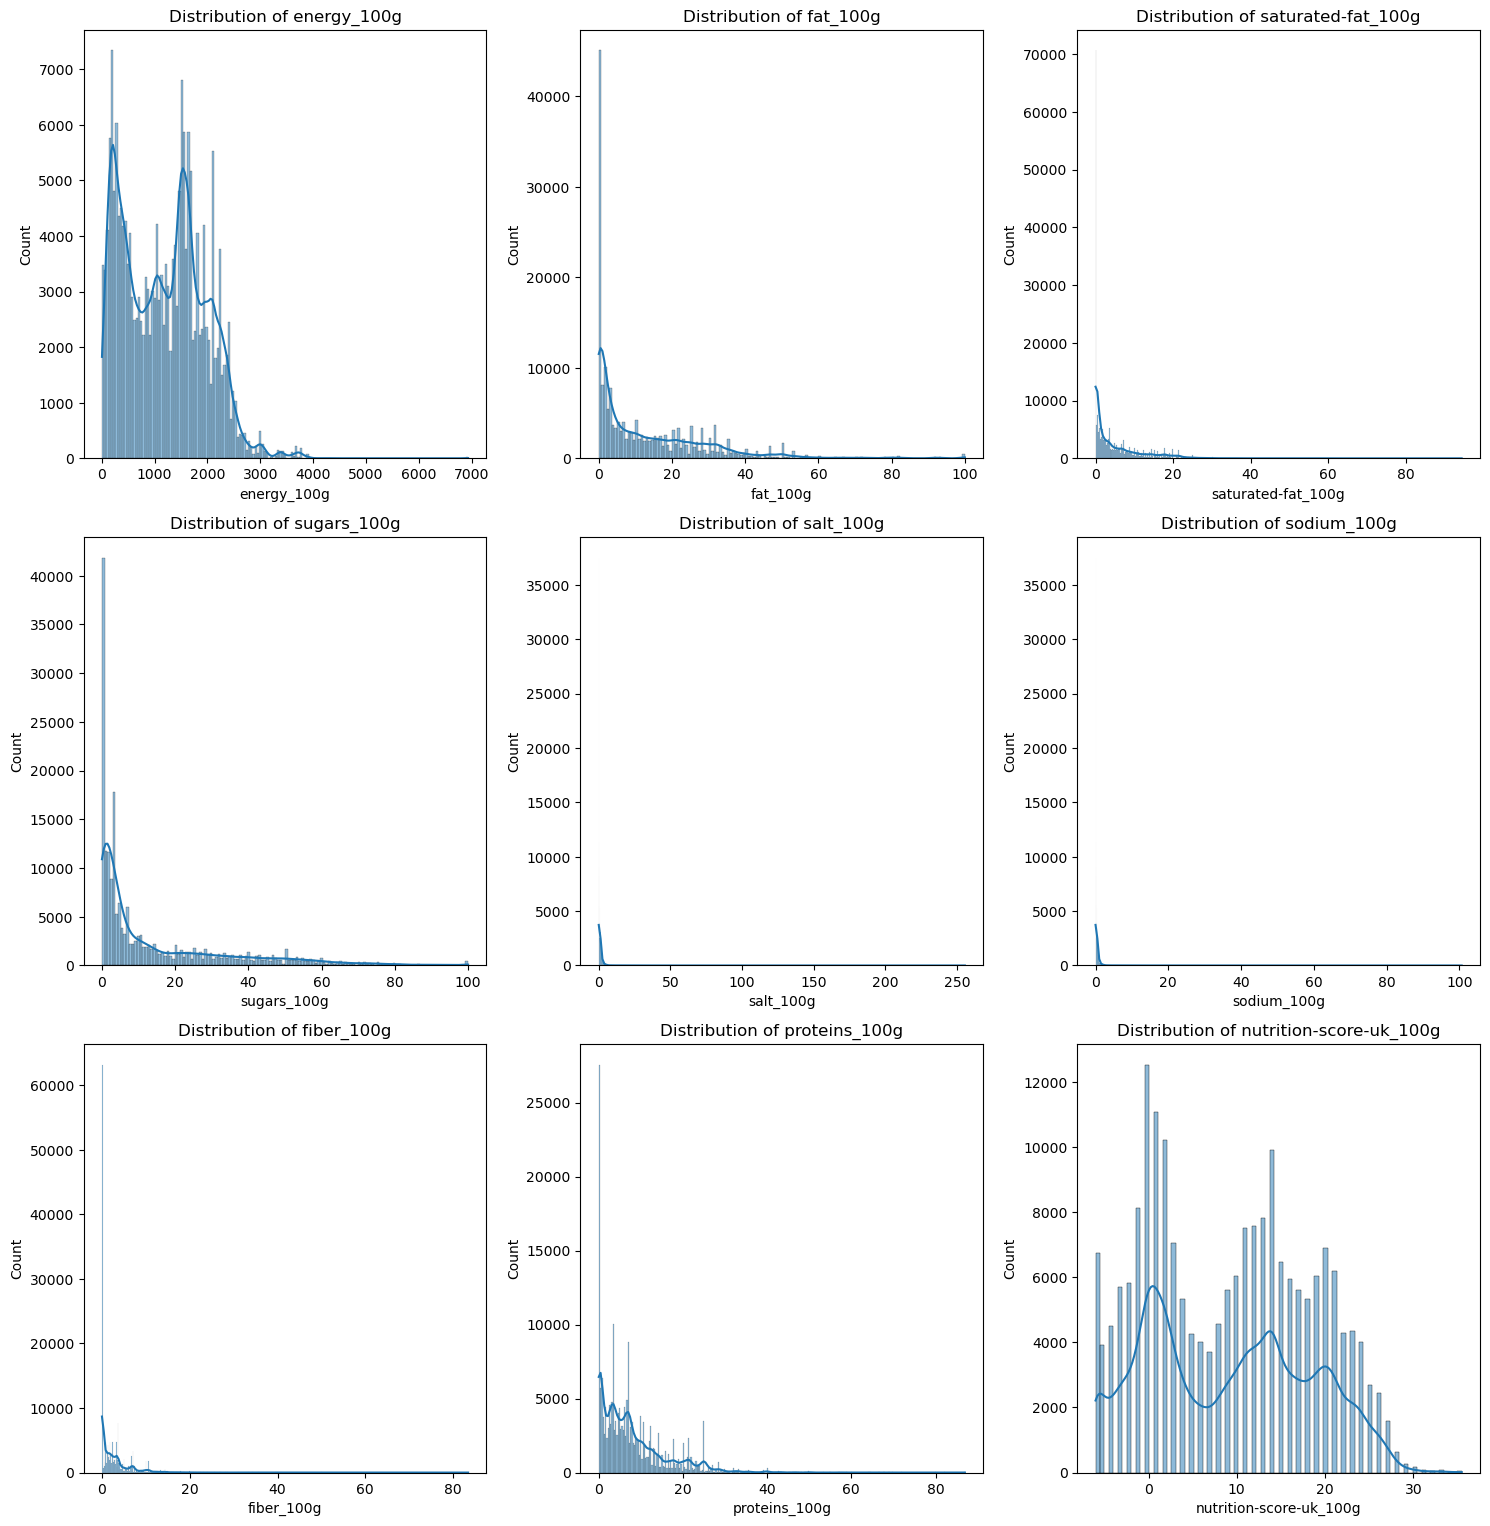

In [15]:
plotHistograms(XClean, numericColumns)

In [16]:
def checkConvert(value, minVal, maxVal, scale):
    if value < minVal or value > maxVal:
        converted_value = value / scale
        if minVal <= converted_value <= maxVal:
            return converted_value
    return value
            
def treatOutliers(data, thresholds):
    dataClean = data.copy()
    for col, (minVal, maxVal) in thresholds.items():
        if col in data.columns:
            if col != 'energy_100g' or col != 'nutrition-score-uk_100g':
                dataClean[col] = dataClean[col].apply(lambda x: checkConvert(x, minVal, maxVal, 1000))
            dataClean.loc[dataClean[col] < minVal, col] = minVal
            dataClean.loc[dataClean[col] > maxVal, col] = maxVal
    return dataClean

['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g', 'nutrition-score-uk_100g']


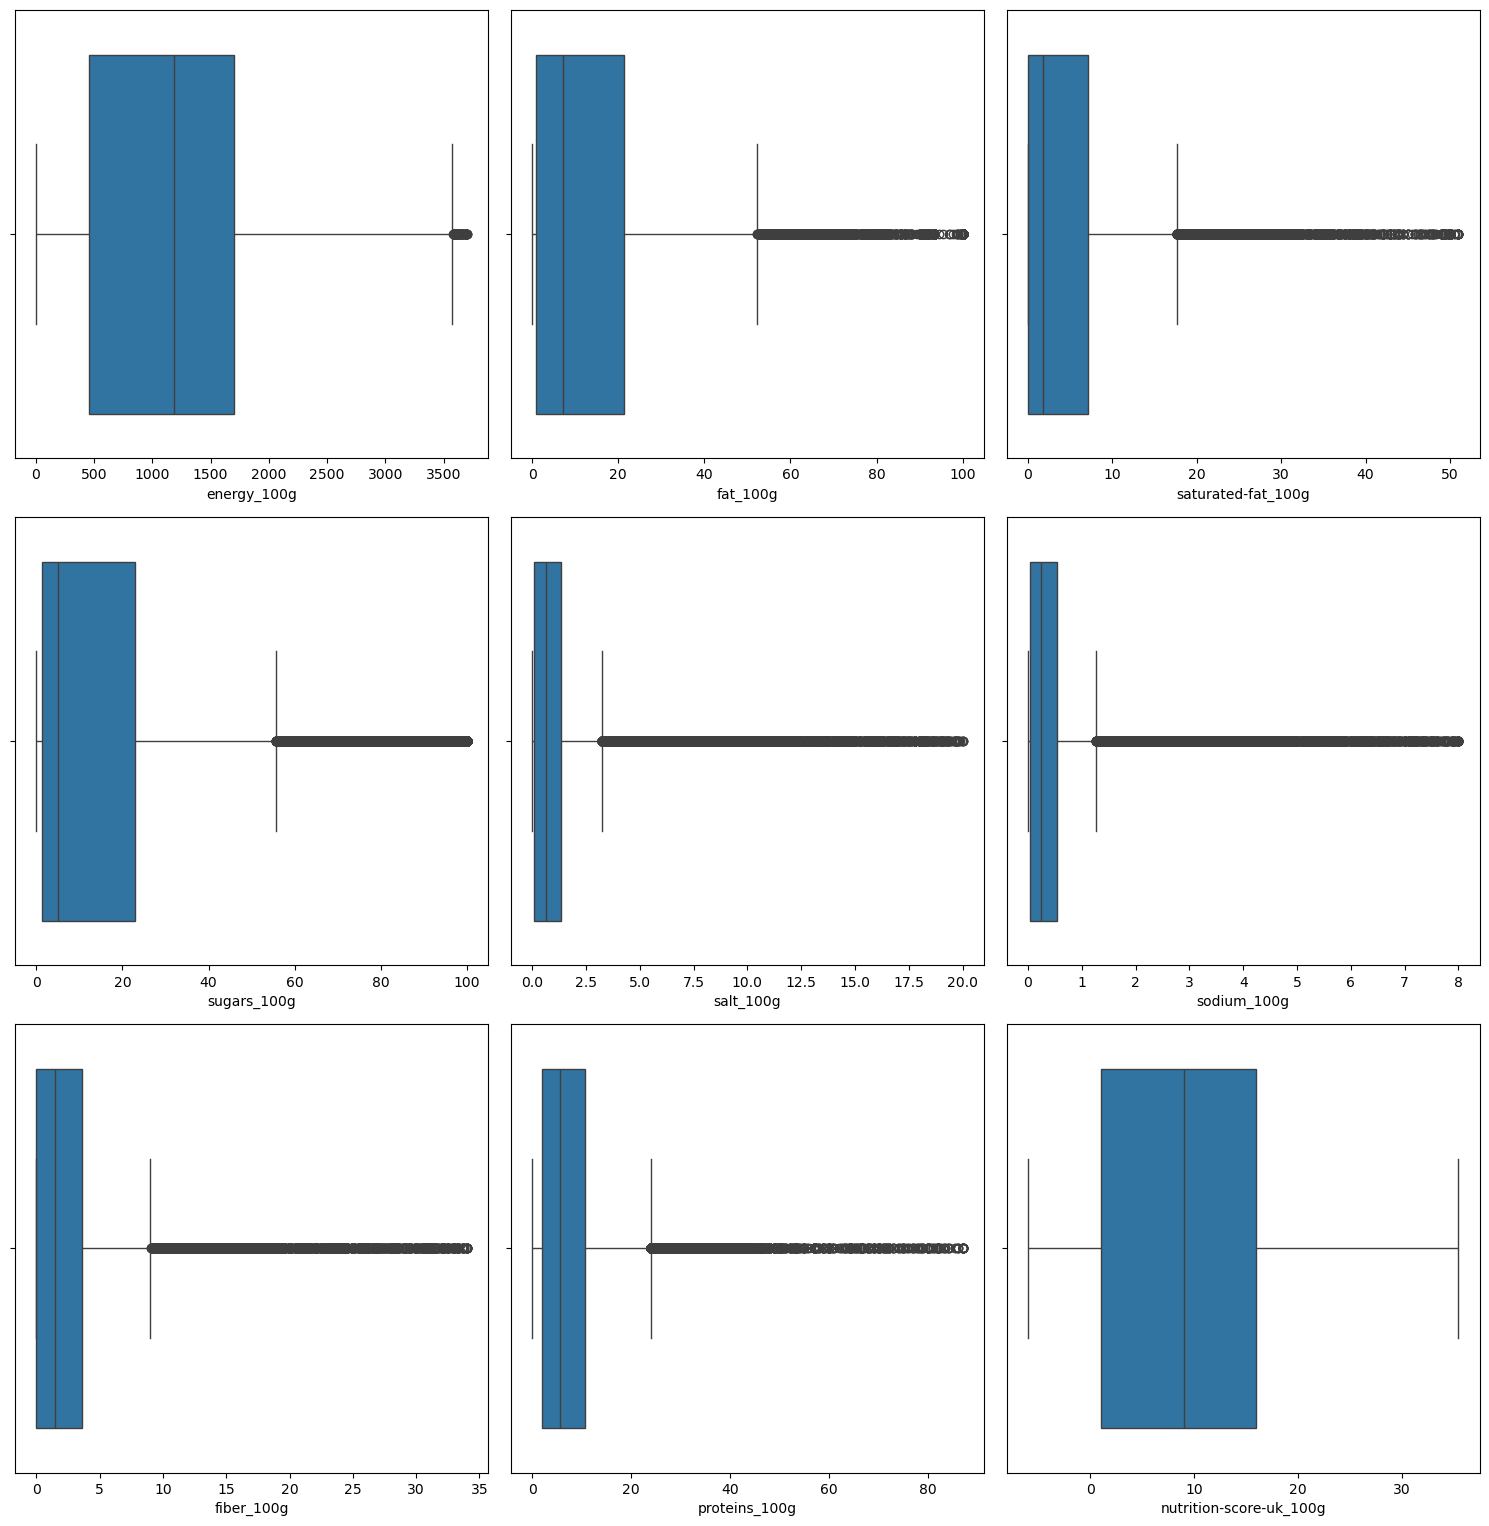

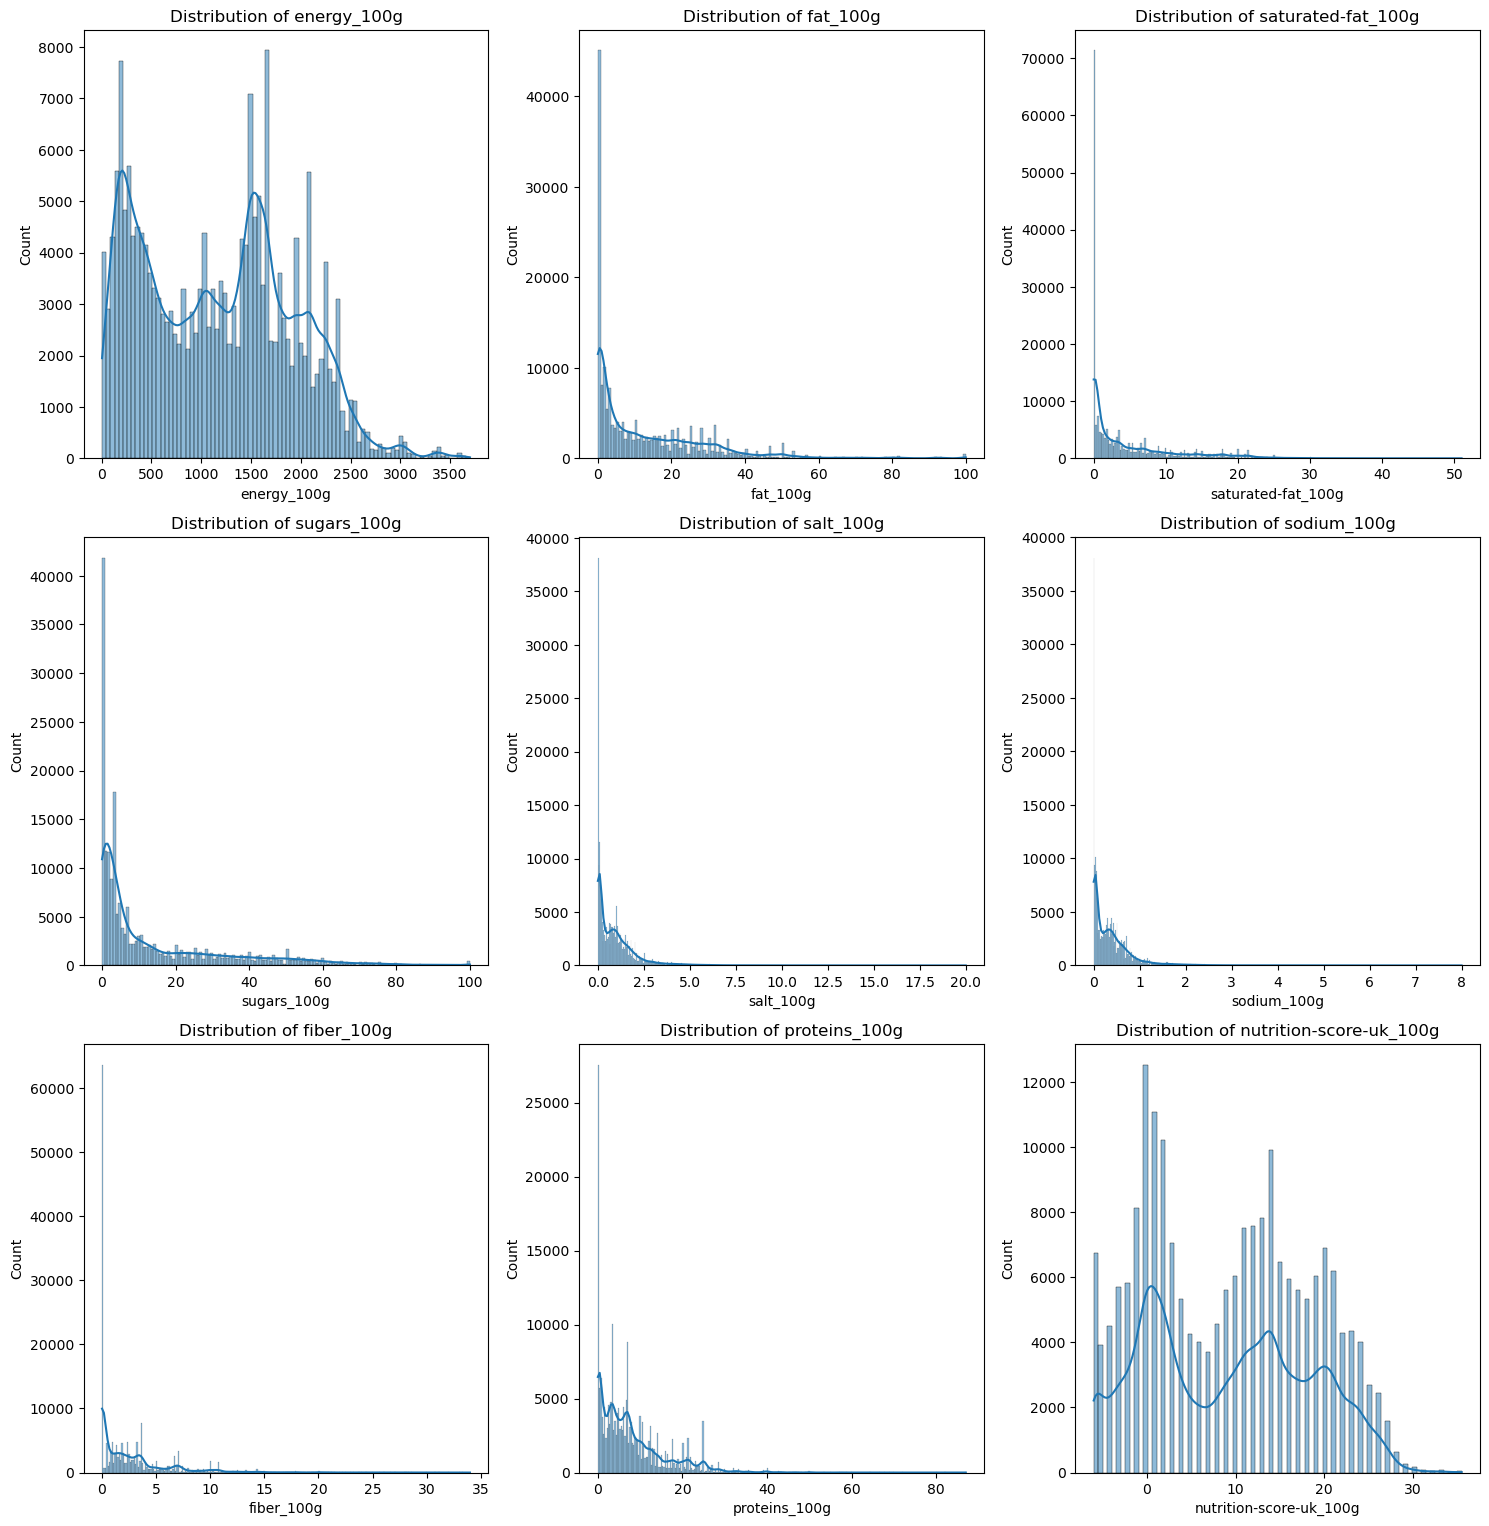

In [17]:
outlierThresholds = {
    'energy_100g': (0, 3699),
    'energy-from-fat_100g' : (0, 3699),
    'fat_100g': (0, 100),
    'saturated-fat_100g': (0, 51),
    'sugars_100g': (0, 100),
    'fiber_100g': (0, 34),
    'proteins_100g': (0, 90),
    'salt_100g': (0, 20),
    'sodium_100g': (0, 8),
    'fruits-vegetables-nuts_100g' : (0, 100),
    'nutrition-score-uk_100g' : (-15, 40)
}

XClean = treatOutliers(XClean, outlierThresholds)
plotBoxplots(XClean, numericColumns)
plotHistograms(XClean, numericColumns)

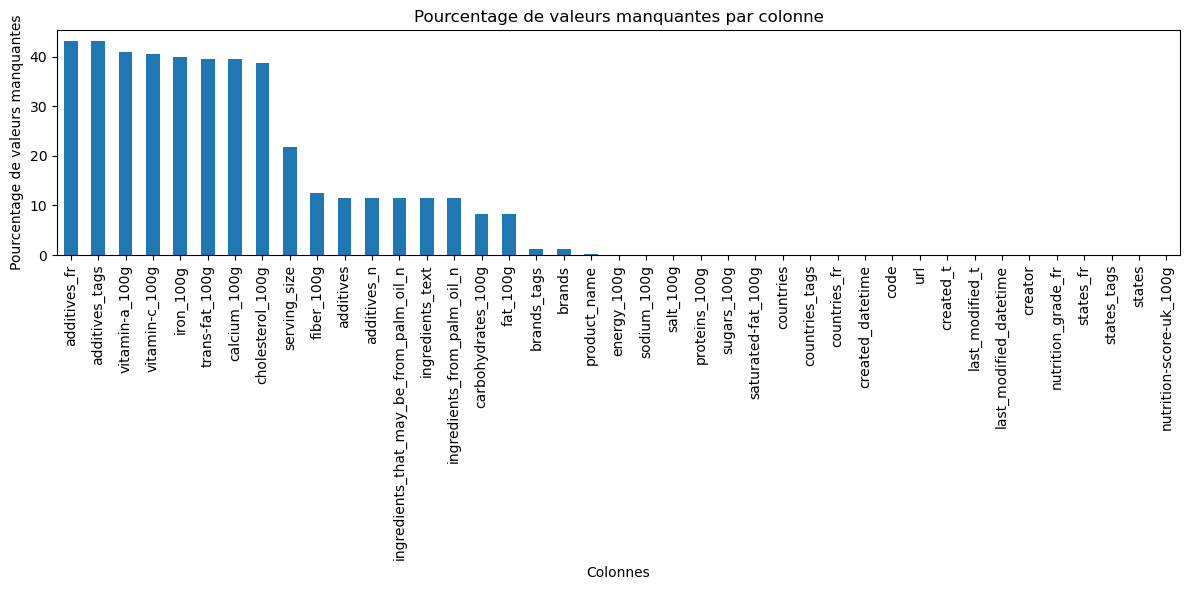

In [18]:
missing_percentages = (XClean.isnull().mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind='bar')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#print(missing_percentages)

In [19]:
def impute_missing_values(data):
    dataImputed = data.copy()
    
    numericColumns = data.select_dtypes(include=[np.number]).columns
    for col in numericColumns:
        if col != "fiber_100g" or col != "proteins_100g" or col != "fruits-vegetables-nuts_100g":
            dataImputed[col] = dataImputed[col].fillna(dataImputed[col].median())
        else:
            dataImputed[col] = dataImputed[col].fillna(0)
    
    return dataImputed

In [20]:
XImputed = impute_missing_values(XClean)
missing_percentages = (XImputed.isnull().mean() * 100).sort_values(ascending=False)

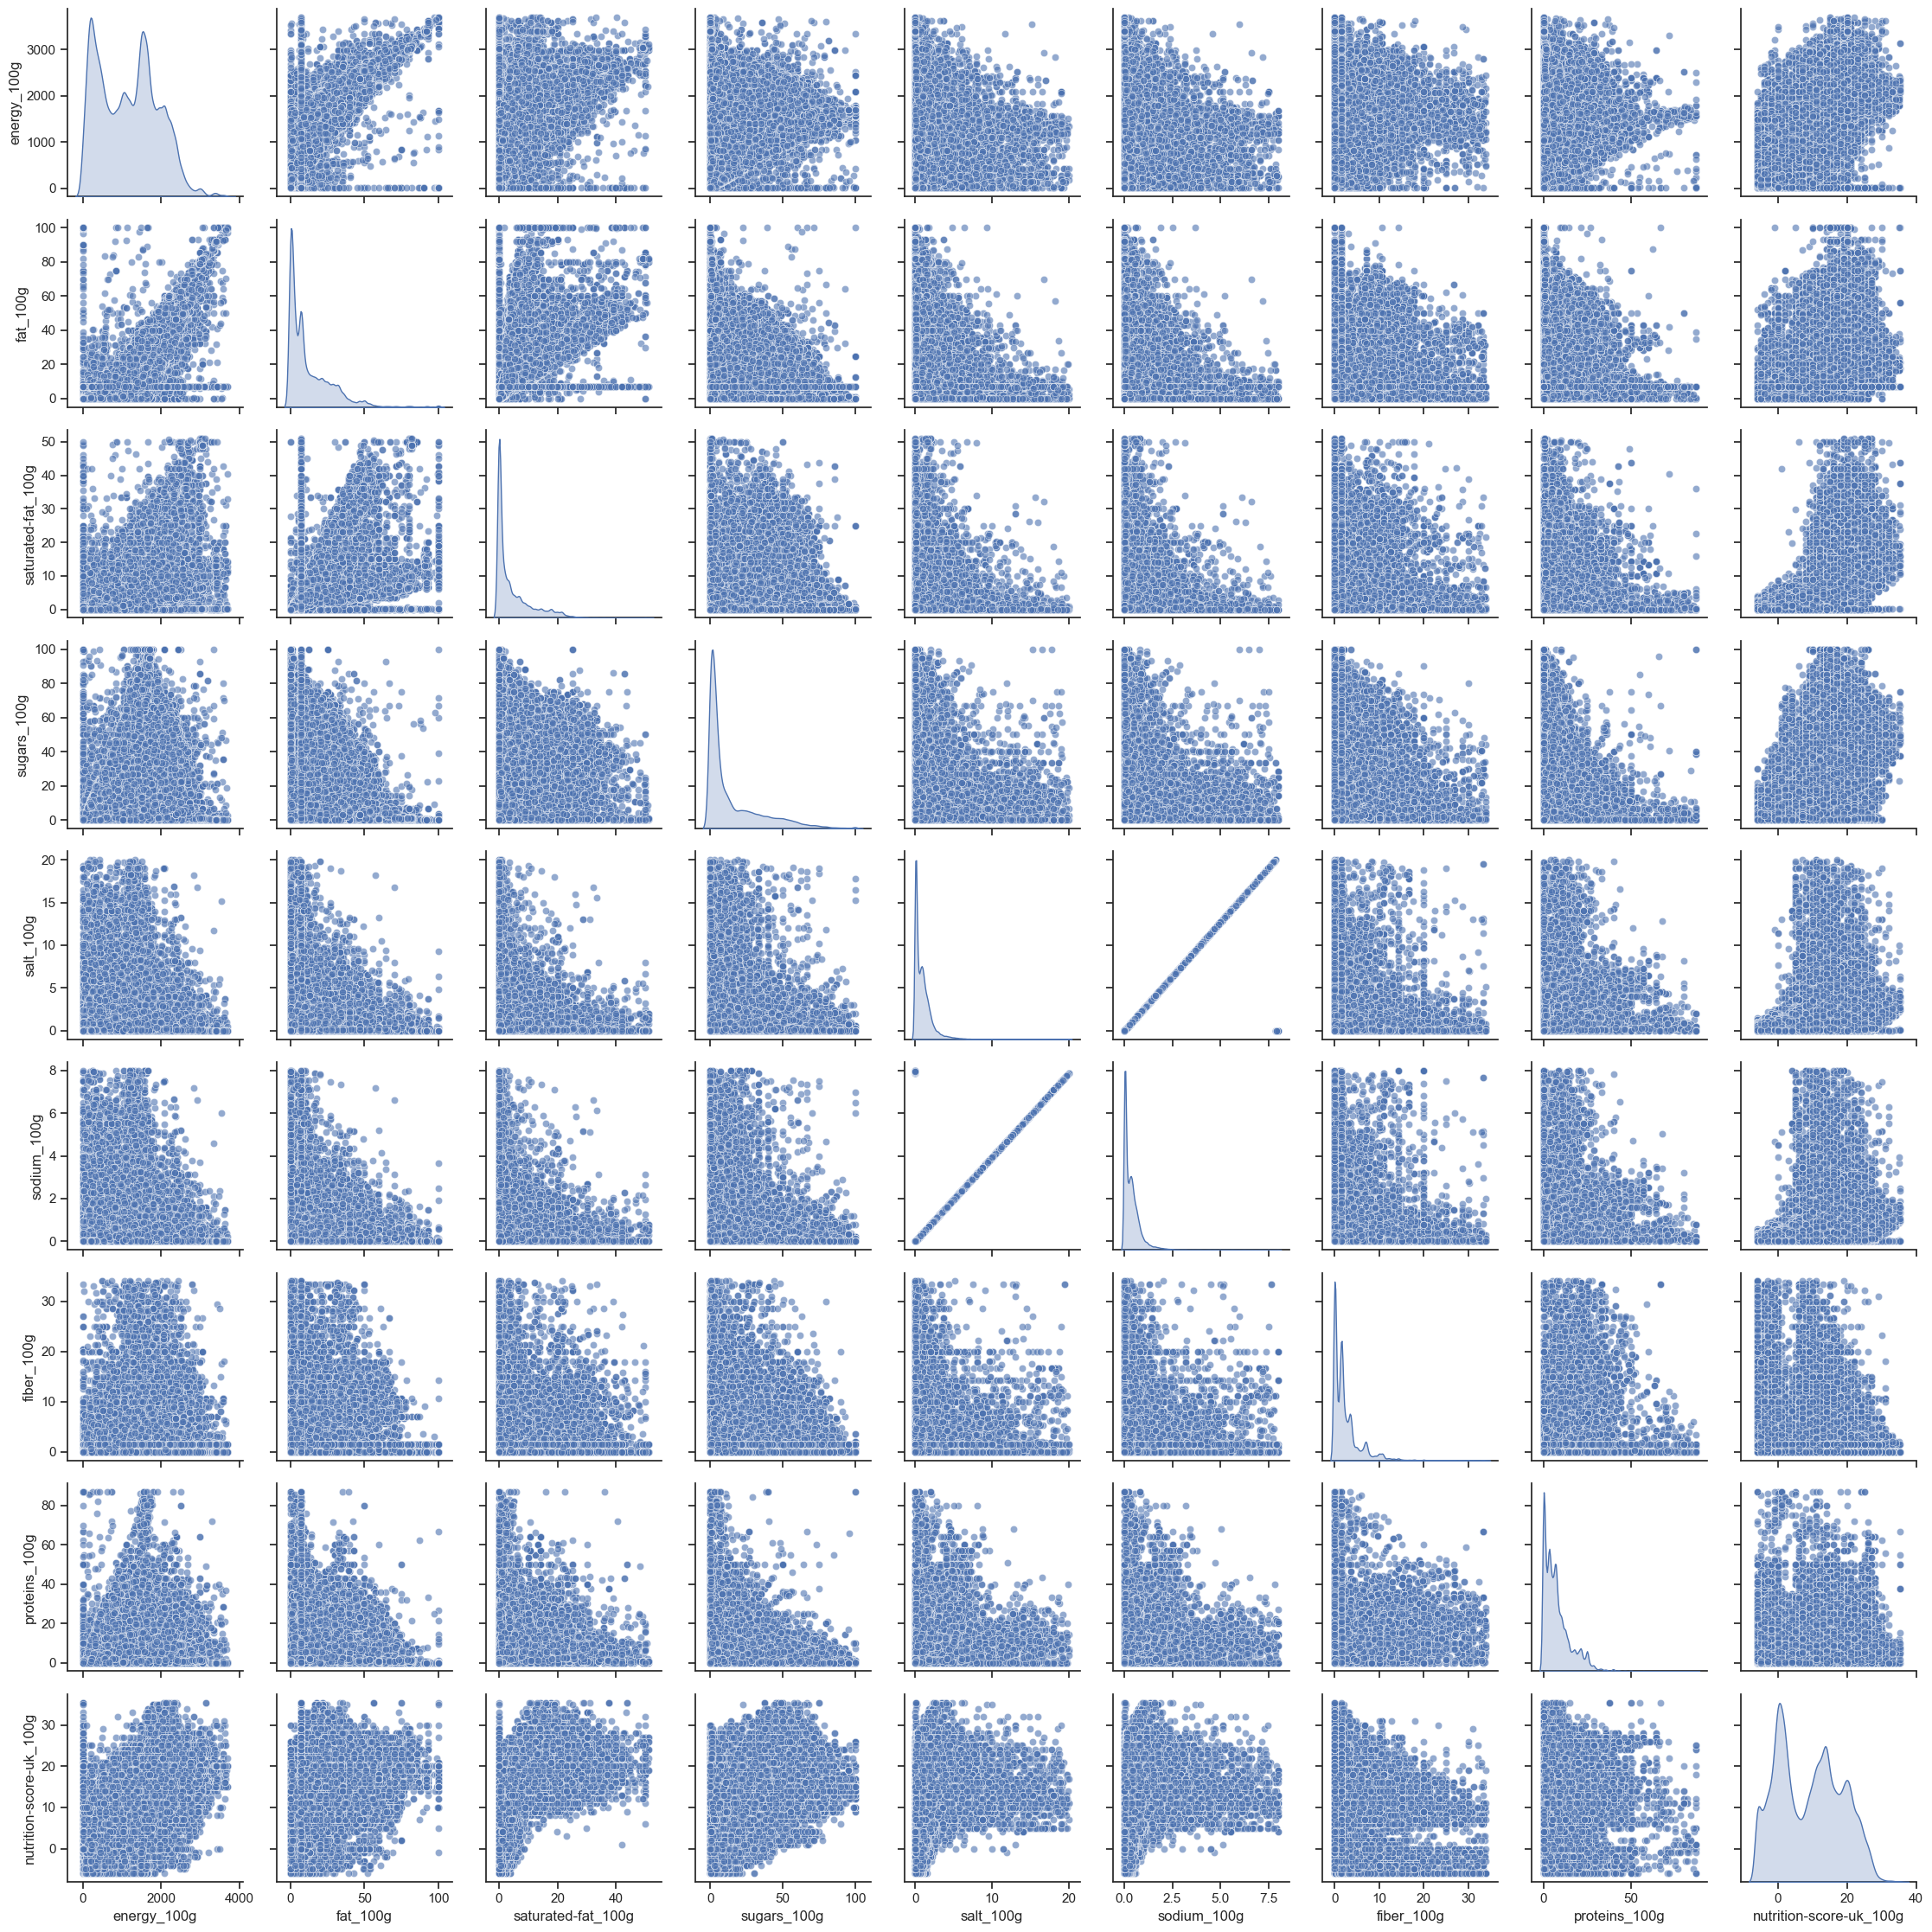

In [21]:
sns.set_theme(style="ticks")
sns.pairplot(XImputed[numericColumns], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()


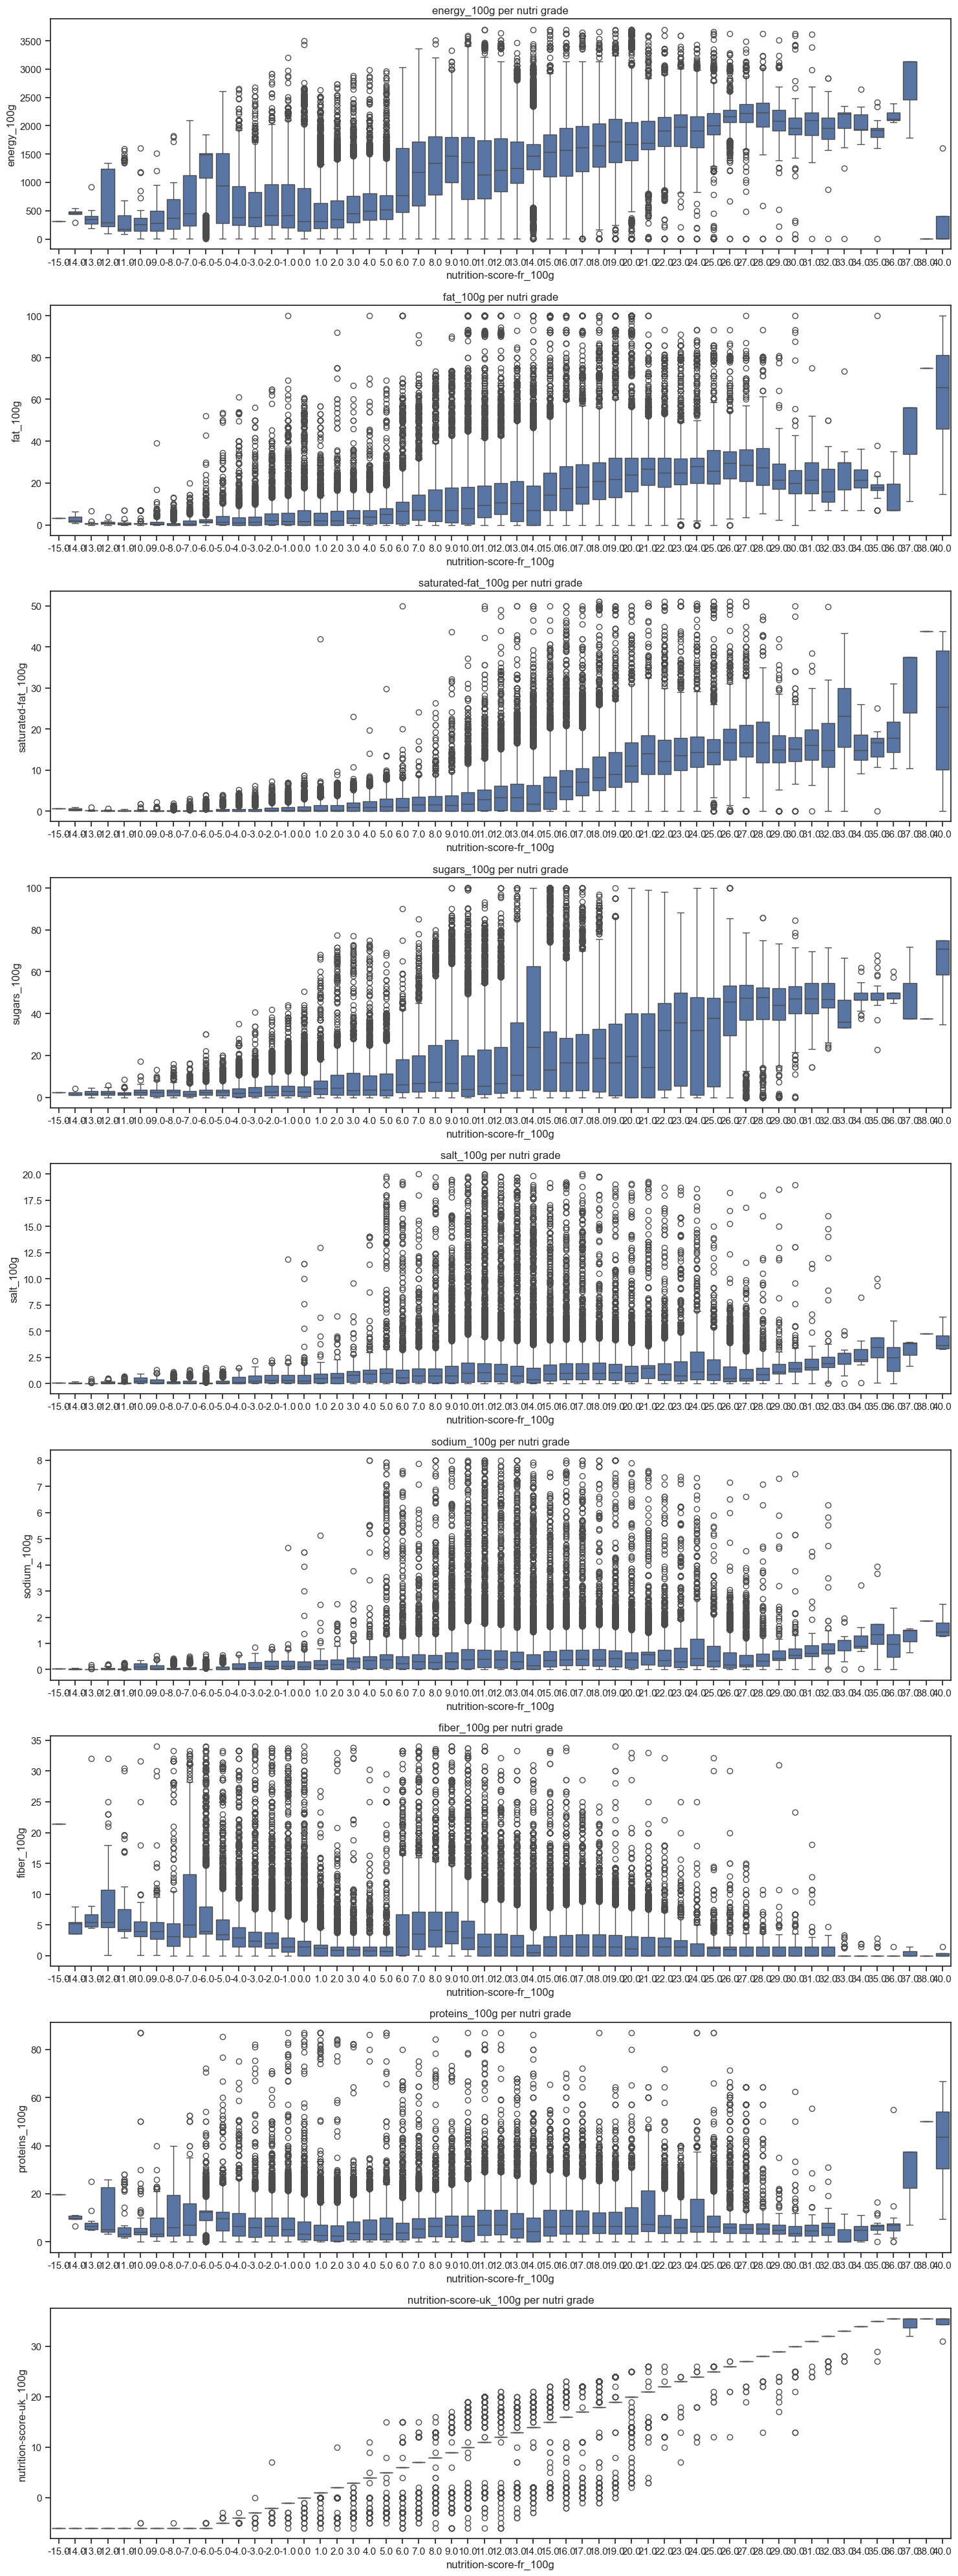

In [22]:
plt.figure(figsize=(15, 40))
for i, var in enumerate(numericColumns, 1):
    if var in XImputed.columns:
        plt.subplot(len(numericColumns), 1, i)
        sns.boxplot(x='nutrition-score-fr_100g', y=var, data=pd.concat([XImputed, y], axis=1))
        plt.title(f'{var} per nutri grade')
plt.tight_layout()
plt.show()

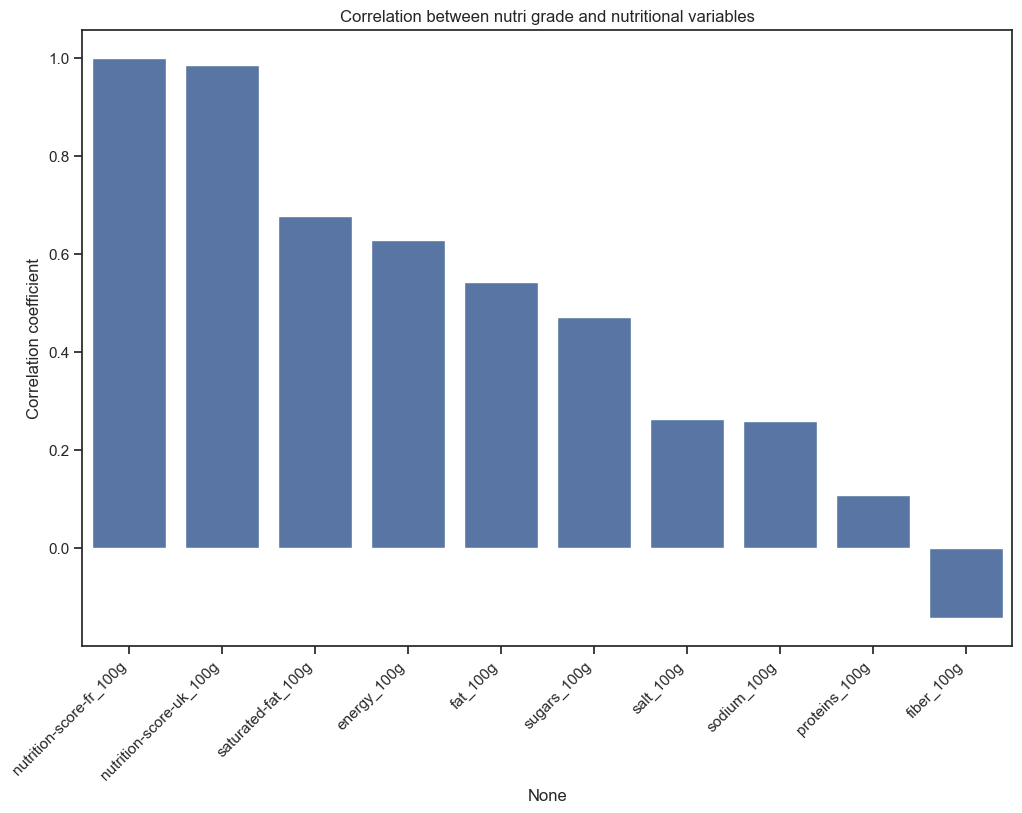

In [23]:
dataCombined = pd.concat([XImputed, y], axis=1)
correlations = dataCombined[numericColumns + [y.name]].corr()[y.name].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation between nutri grade and nutritional variables')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation coefficient')
plt.show()

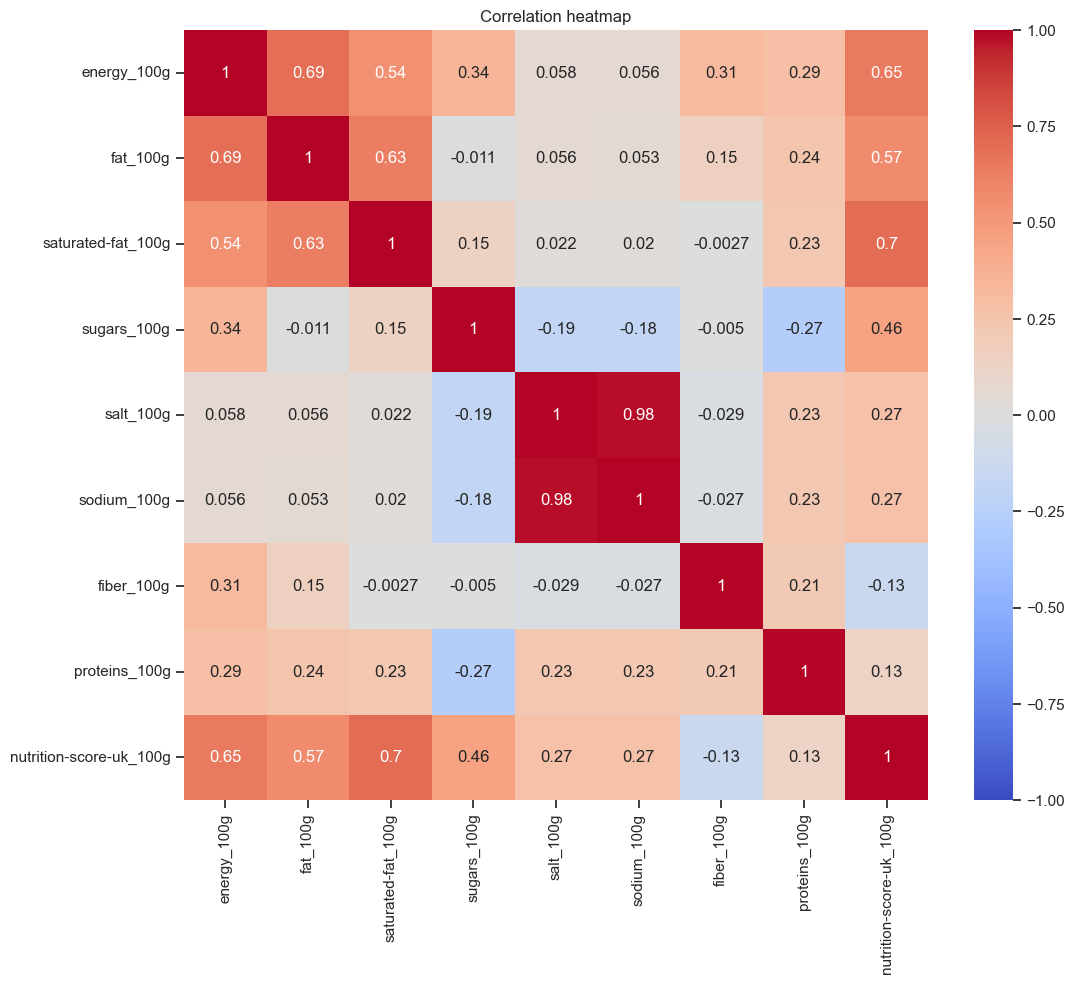

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(dataCombined[numericColumns].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation heatmap')
plt.show()

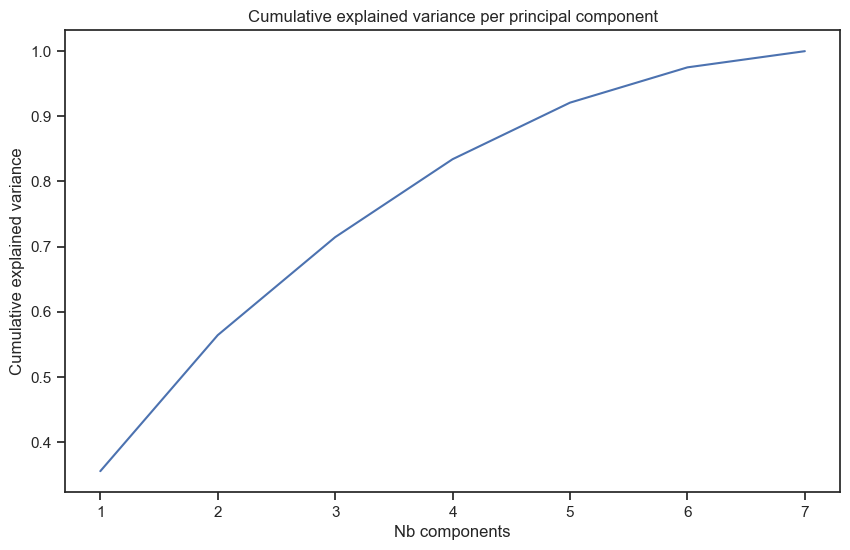

In [25]:
if 'nutrition-score-uk_100g' in numericColumns:
	numericColumns.remove('nutrition-score-uk_100g')
if 'sodium_100g' in numericColumns:
	numericColumns.remove('sodium_100g')
scaler = StandardScaler()
XScaled = scaler.fit_transform(XImputed[numericColumns])

pca = PCA()
XPca = pca.fit_transform(XScaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nb components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance per principal component')
plt.show()

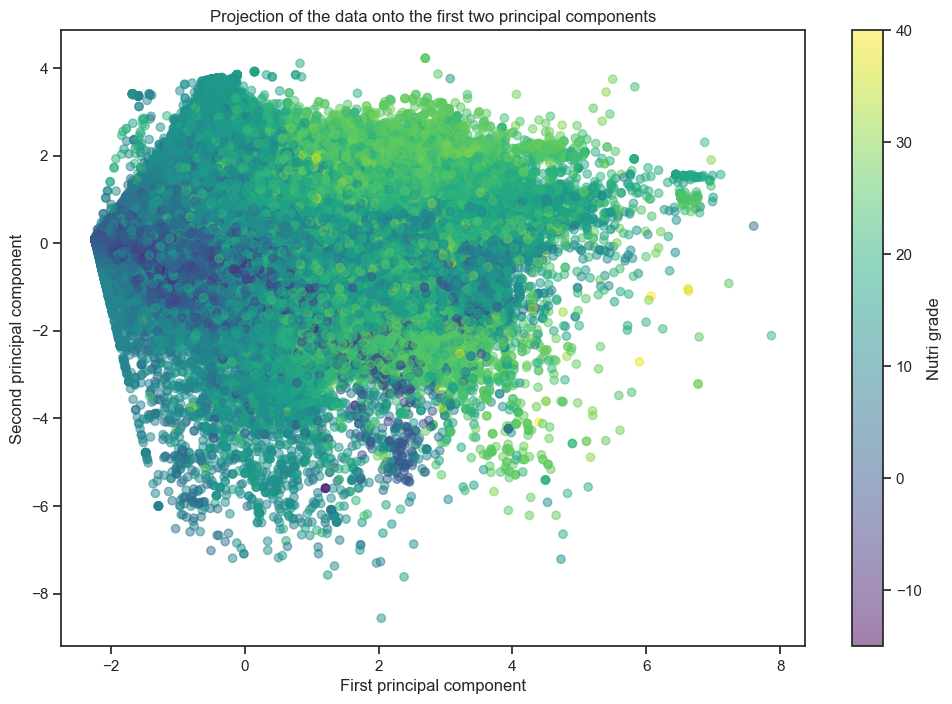

In [26]:
plt.figure(figsize=(12, 8))
plt.scatter(XPca[:, 0], XPca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of the data onto the first two principal components')
plt.colorbar(label='Nutri grade')
plt.show()

In [27]:
for var in numericColumns:
    if var in XImputed.columns:
        groups = [group for _, group in XImputed[var].groupby(y)]
        f_value, p_value = stats.f_oneway(*groups)
        print(f"ANOVA for {var}:")
        print(f"F-value: {f_value}")
        print(f"p-value: {p_value}")
        print("\n")

ANOVA for energy_100g:
F-value: 3404.9517315379694
p-value: 0.0


ANOVA for fat_100g:
F-value: 1763.0461911918815
p-value: 0.0


ANOVA for saturated-fat_100g:
F-value: 4393.642610168355
p-value: 0.0


ANOVA for sugars_100g:
F-value: 1382.2943698245892
p-value: 0.0


ANOVA for salt_100g:
F-value: 361.87678738694325
p-value: 0.0


ANOVA for fiber_100g:
F-value: 624.9894638982086
p-value: 0.0


ANOVA for proteins_100g:
F-value: 197.748254522884
p-value: 0.0




Les résultats suggèrent que la variable nutrition-score-fr_100g est statistiquement significative pour prédire les niveaux de différentes variables nutritionnelles. Cela peut être utile pour comprendre comment les différentes classes de nutrition-score-fr_100g sont associées à des profils nutritionnels spécifiques dans votre ensemble de données.
nutrition-score-fr_100g avec les categorie des aliment peuvent aider a donner le nutrition_grade_fr